# Introduction to LangGraph - Module 2: State and Memory

# Pre-requisites

In [16]:
!pip install -qU langgraph langchain_openai langchain_core langgraph-prebuilt langgraph-checkpoint-sqlite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 9.5 MB/s eta 0:00:00


# State Schema

In module 1, we knew and built up a ReAct agent that can
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions

## Schema

When we define a LangGraph `StateGraph`, we need to use a *state* schema. This represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

## TypedDict

`TypedDict` is a dictionary subclass from Python's standard library that allows us to specify keys and value types.

NOTE that these are type hints. They can be used by static type checkers (like `mypy`) or IDEs to catch potential type-releated errors before the code is run. However, they are not enforced at runtime.

In [2]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

For more specific value constraints, we should use things like the `Literal` type hint. For example, here, `mood` can only either `"happy"`, or `"sad"`.

In [3]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy", "sad"]

As an example, we can use our defined state class in LangGraph by simply passing it to `StateGraph`.

Each state key is just a "channel" in our graph. We will overwrite the value of a specified key or "channel" in each node.

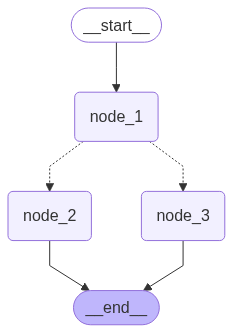

In [6]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Since our state is a dictionary, we can invoke the graph with a dictionary to set an initial value of the `name` key in our state as the `name` key is the only required field to start the graph.

In [13]:
graph.invoke({'name': 'Bin'})

---Node 1---
---Node 2---


{'name': 'Bin is ... ', 'mood': 'happy'}

## Dataclass

Python's `dataclasses` provide another way to define structured data.

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [14]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy", "sad"]

To access the keys of a `dataclass`, we need to write `state.name` instead of `state['name']`.

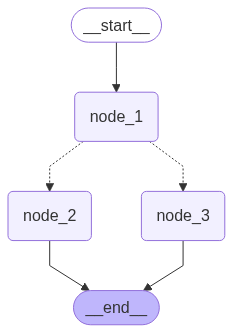

In [17]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We will invoke a `dataclass` to set the initial values of each key/channel in our state:

In [19]:
graph.invoke(
    DataclassState(name='Bin', mood='happy')
)

---Node 1---
---Node 2---


{'name': 'Bin is ... ', 'mood': 'happy'}

## Pydantic

Neither `TypedDict` or `dataclasses` provide type hints but they do not enforce types at runtime.

This means that we could potentially assign invalid values without raising an error:

In [20]:
dataclass_instance = DataclassState(name="Bin", mood="mad")

In [21]:
typed_dict_instance = TypedDictState(name="Bin", mood="mad")

Pydantic is a data validation and settings management library using Python type annotations.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [22]:
from pydantic import BaseModel, field_validator, ValidationError


class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad"

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError('mood must be either "happy" or "sad"')
        return value

In [23]:
try:
    state = PydanticState(name="Bin", mood="mad")
except ValidationError as e:
    print("Validation error:", e)

Validation error: 1 validation error for PydanticState
mood
  Value error, mood must be either "happy" or "sad" [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


Now we can use `PydanticState` in our graph seamlessly.

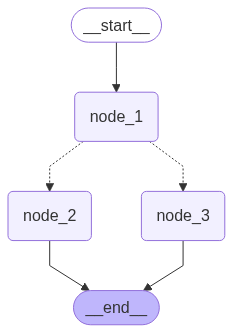

In [24]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
graph.invoke(PydanticState(name="Bin", mood="happy"))

---Node 1---
---Node 3---


{'name': 'Bin is ... ', 'mood': 'sad'}

In [27]:
graph.invoke(PydanticState(name="Bin", mood="mad"))

ValidationError: 1 validation error for PydanticState
mood
  Value error, mood must be either "happy" or "sad" [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error

# State Reducers

The **reducers** specify how state updates are performed on specific keys/channels in the state schema.

## Default overwriting state

Assume we still use `TypedDict` as our state schema

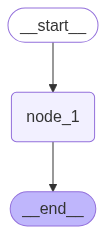

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    foo: int


def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}


# build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# logic
builder.add_edge(START, 'node_1')
builder.add_edge('node_1', END)

# compile
graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({'foo': 1})

---Node 1---


{'foo': 2}

By default, the prior state was overwritten by the returned state.

## Branching

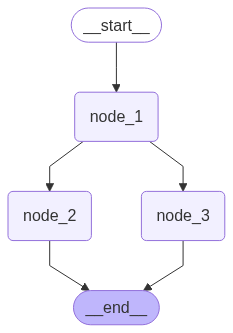

In [4]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({'foo': 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In this graph, Node 1 branches to Nodes 2 and 3 in parallel, which means they run in the same step of the graph. Both Nodes 2 and 3 attempt to overwrite the state *within the same step*. This is ambiguous for the state update in this graph, and this is the reason why the `InvalidUpdateError` occurred.

## Reducers

**Reducers** give us a general way to address this issue. Reducers specify how to perform updates.

We can use the `Annotated` type to specify a *reducer function*. For example, in this graph, we will append the value returned from each node rather than overwriting them.

To achieve this, we just need a recuder function that can perform this: `operator.add` is a function from Python built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

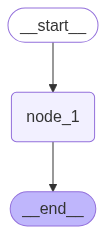

In [6]:
from operator import add
from typing import Annotated


# Update state schema
class State(TypedDict):
    foo: Annotated[list[int], add]


def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list.

The value of new state is appended to the previous state. Because the key `foo` now has a reducer function `operator.add`, it now knows how to handle state updates rather than overwriting.


Now if we get back to our branching graph:

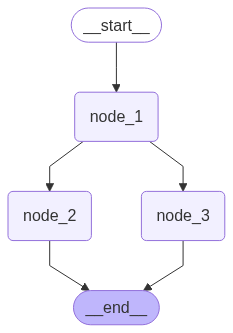

In [10]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 2]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 3]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 4, 5]}

To illustrate this, the initial state has a list `[1]`, and then goes to `node_1` and gets `[1, 2]`. The most recent value is `2`. Then this state goes to `node_2` and `node_3` in parallel:
- `node_2` takes a list `[1, 2]` and returns value `4`
- `node_3` takes a list `[1, 2]` and returns value `5`

Then they append the new state to the previous input state resulting in the final state `[1, 2, 4, 5]`.

If we pass `None` to `foo`:

In [12]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


The `operator.add` reducer function attempts to concatenate `NoneType` pass as input to list in `node_1`.

## Custom Reducers

To address cases like the `NoneType` issue, we can also define custom reducers. For example, we can define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [14]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
        If either input is None, a new empty list is returned.
    """
    if not left:
        left = []
    if not right:
        right = []

    return left + right

In [15]:
class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

If we pass a `None` value to a graph using the `DefaultState`:

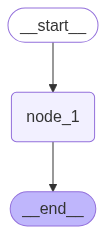

TypeError occurred: can only concatenate list (not "NoneType") to list


In [16]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

However, if we try with our custom reducer:

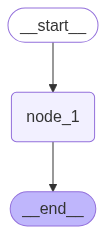

---Node 1---
{'foo': [2]}


In [17]:
# Build graph
builder = StateGraph(CustomReducerState) # State with custom reducer
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

No error is thrown now.

## Messages

In Module 1, we have applied a built-in reducer, `add_messages`, to handle messages in state.

We also saw a `MessagesState` which is a shortcut if we want to work with messages:
- `MessagesState` has a built-in `messages` key.
- It also has a built-in `add_messages` reducer for this key.

We can use the `MessagesState` class for brevity:

In [18]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# Define a custom `TypedDict` that includes a list of messages with `add_messages` reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str


# Equivalently,
# Use `MessagesState`, which includes the `messages` key with `add_messages` reducer
class ExtendMessagesState(MessagesState):
    # Add any keys needed beyond `messages`, which is pre-built
    added_key_1: str
    added_key_2: str

In [19]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='78111f57-a81d-4179-a015-23bd6a8f0baa'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='11ba1ae0-221f-4fdc-9c31-f678e9a98658'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='cccfba75-edee-4a45-a2b6-1d8755405191')]

The `new_message` will be appended to the `initial_messages` using our `add_messages` reducer function.

We now have two tricks to work with the `add_messages` reducer, **re-writing** and **removal**:

### Rewriting

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten:

In [20]:
# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model", id="1"), # added ID
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2") # added ID
]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2") # same existing ID

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

Now instead of appending `new_message`, the `add_messages` overwrites the exisitng message since we provides an existing ID.

### Removal

We can also use `add_messages` to remove a message.

To enable this, we need to use `RemoveMessage` from `langchain_core`:

In [25]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

In [26]:
# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]] # delete meesages up to the most recent 2 ones

delete_messages

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]

In [24]:
# Now actually execute the deletion
add_messages(messages, delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

We can see that messages with IDs 1 and 2 are removed by the reducer, as noted in `delete_messages`.

# Multiple Schemas

Typically, all graph nodes communicate with a single schema. This single schema contains the graph's input and output keys/channels.

However, there are cases where we may want more control over the states:
- Internal nodes may pass information that is *not required* in the graph's input/output. This can be internal communication between nodes that should not be exposed to the users.
- We may want to use different input/output schemas for the graph. The output may only contain a single relevant output key, which is not present in the input schema.

## Private State

The private state is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

Assume that we have two states `OverallState` and `PrivateState`, and the `node_2` will use `PrivateState` as input, but write out to `OverallState`.

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    bar: int

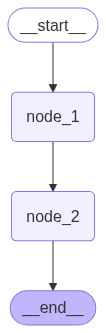

In [3]:
def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {'bar': state['foo'] + 1}


def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {'foo': state['bar'] + 1}


# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

We see that `bar` is only included in `PrivateState`, and `node_2` uses `PrivateState` as input, but writes out to `OverallState`.

Hence, `bar` is excluded from the graph output because it is not in `OverallState`.

## Input/Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema.

However, it is also possible to define explicit input and output schemas for a graph.

In these cases, we define an "internal" schema that contains *all* keys relevant to graph operations. However, we use specific `input` and `output` schemas to constrain the input and output.


First, we will run the graph with a single schema:

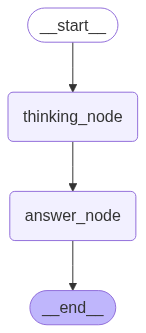

In [5]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: OverallState):
    return {
        'answer': 'bye',
        'notes': '... his name is Bin.'
    }

def answer_node(state: OverallState):
    return {
        'answer': 'bye Bin.'
    }



# Builder graph
builder = StateGraph(OverallState)
builder.add_node('thinking_node', thinking_node)
builder.add_node('answer_node', answer_node)

# Logic
builder.add_edge(START, 'thinking_node')
builder.add_edge('thinking_node', 'answer_node')
builder.add_edge('answer_node', END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Bin.', 'notes': '... his name is Bin.'}

The output of invoke contains all keys in `OverallState`.

Now if we use a specific `input` and `output` schema with our graph. The `input` and `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph.

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes. This is important when the graph uses *multiple schemas*.

We use *type hints* to show that the output of `answer_node` will be filtered to `OutputState`:

In [10]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: InputState): # use `InputState` as input
    return {
        'answer': 'bye',
        'notes': '... his name is Bin.'
    }

def answer_node(state: OverallState) -> OutputState: # return `OutputState` as output
    return {
        'answer': 'bye Bin.'
    }

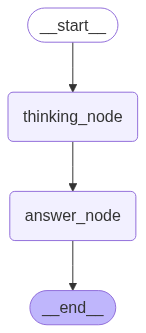

In [11]:
# Builder graph
builder = StateGraph( # MAIN CHANGES
    OverallState,
    input_schema=InputState,
    output_schema=OutputState,
)
builder.add_node('thinking_node', thinking_node)
builder.add_node('answer_node', answer_node)

# Logic
builder.add_edge(START, 'thinking_node')
builder.add_edge('thinking_node', 'answer_node')
builder.add_edge('answer_node', END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"question":"hi"})

{'answer': 'bye Bin.'}

Notice that the `output` schema constrains the output to only the `answer` key now!

# Filtering and Trimming Messages

In [14]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')
os.environ['LANGSMITH_TRACING_V2'] = 'true'

## Messages as State

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching LangGraph?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about LangGraph and LangSmith. But what others should I learn about?", name="Bin"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching LangGraph?
================================ Human Message =================================
Name: Bin

Yes, I know about LangGraph and LangSmith. But what others should I learn about?


In [16]:
# Set up an LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o')

In [17]:
llm.invoke(messages)

AIMessage(content="If you're interested in LangGraph and LangSmith, here are a few more concepts and tools you might want to explore, especially if you're delving into the field of language models, data processing, and natural language processing (NLP):\n\n1. **LangChain**: A framework designed to facilitate the creation of language model applications. It's useful for integrating large language models (LLMs) with various data sources and tools.\n\n2. **OpenAI GPT and Codex**: Understanding the capabilities and APIs of models like GPT-3, GPT-4, and Codex can be crucial. They are widely used for a variety of NLP tasks.\n\n3. **Transformers Library (by Hugging Face)**: A popular library that provides a wide array of pre-trained models for various NLP tasks, enabling fine-tuning and deployment.\n\n4. **Prompt Engineering**: The practice of designing and refining prompts to effectively communicate with language models to obtain desired results.\n\n5. **Vector Databases**: Learn about vector

We can run our chat model in a simple graph with `MessagesState`.

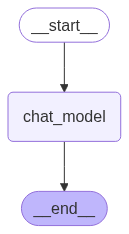

In [18]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END


# Node
def chat_model_node(state: MessagesState):
    messages = llm.invoke(state['messages'])

    return {'messages': messages}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node('chat_model', chat_model_node)

# Logic
builder.add_edge(START, 'chat_model')
builder.add_edge('chat_model', END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching LangGraph?
================================ Human Message =================================
Name: Bin

Yes, I know about LangGraph and LangSmith. But what others should I learn about?
================================== Ai Message ==================================

LangGraph and LangSmith are indeed powerful tools for handling language models and AI workflows. Beyond these, you might want to consider the following tools and frameworks:

1. **LangChain**: This is a framework for developing applications powered by language models. It provides mechanisms to integrate different components and manage workflows effectively, particularly for building more complex AI applications.

2. **Hugging Face Transformers**: This library provides a wide array of pre-trained models for natural language processing tasks and is widely used for both research and production purposes. I

## Reducer

The challenge to work with messages is to manage long-running conversations. Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

One way to address this is to use `RemoveMessage` and the `add_messages` reducer:

In [26]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]

    return {'messages': delete_messages}

def chat_model_node(state: MessagesState):
    messages = llm.invoke(state['messages'])

    return {'messages': messages}

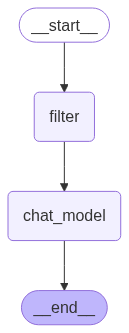

In [27]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node('filter', filter_messages)
builder.add_node('chat_model', chat_model_node)

# Logic
builder.add_edge(START, 'filter')
builder.add_edge('filter', 'chat_model')
builder.add_edge('chat_model', END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Bin", id="2"))
messages.append(AIMessage("So you said you were researching LangGraph?", name="Bot", id="3"))
messages.append(HumanMessage(f"Yes, I know about LangGraph and LangSmith. But what others should I learn about?", name="Bin", id="4"))


# Invoke
output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching LangGraph?
================================ Human Message =================================
Name: Bin

Yes, I know about LangGraph and LangSmith. But what others should I learn about?
================================== Ai Message ==================================

In addition to LangGraph and LangSmith, there are several other tools and frameworks that you might find interesting in the field of natural language processing (NLP) and language modeling. Here are a few noteworthy ones:

1. **Hugging Face Transformers**: Hugging Face provides a wide range of pre-trained models and tools for NLP tasks such as text classification, translation, and more. Their Transformers library is widely used for building and deploying transformer-based models.

2. **spaCy**: A popular and efficient library for NLP in Python, spaCy is known for its focus on providing a fast and produ

We see that the first two messages were deleted from the conversation.

## Filtering messages

If we do not need or want to modify the graph state, we can filter the messages we pass to the chat model.

For example, we can just pass in a filtered list `messages[-1]` to the chat model in the invoke call `llm.invoke(messages[-1:])`. In this way the chat model only uses the last message for generation.

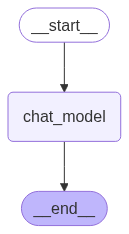

In [29]:
# Node
def chat_model_node(state: MessagesState):
    messages = llm.invoke(state['messages'][-1:])

    return {'messages': messages}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

The logic behind `messages = llm.invoke(state['messages'][-1:])` is that each invocation from the LLM only considers the last message in the `MessagesState` even though the `MessagesState` keeps all conversation.

In [30]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about LangSmith!", name="Bin"))

In [31]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Bin

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching LangGraph?
================================ Human Message =================================
Name: Bin

Yes, I know about LangGraph and LangSmith. But what others should I learn about?
================================== Ai Message ==================================

In addition to LangGraph and LangSmith, there are several other tools and frameworks that you might find interesting in the field of natural language processing (NLP) and language modeling. Here are a few noteworthy ones:

1. **Hugging Face Transformers**: Hugging Face provides a wide range of pre-trained models and tools for NLP tasks such as text classification, translation, and more. Their Transformers library 

We can see that the `messages` keeps every converstion history.

In [32]:
# Invoke using message filtering
output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Bin

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching LangGraph?
================================ Human Message =================================
Name: Bin

Yes, I know about LangGraph and LangSmith. But what others should I learn about?
================================== Ai Message ==================================

In addition to LangGraph and LangSmith, there are several other tools and frameworks that you might find interesting in the field of natural language processing (NLP) and language modeling. Here are a few noteworthy ones:

1. **Hugging Face Transformers**: Hugging Face provides a wide range of pre-trained models and tools for NLP tasks such as text classification, translation, and more. Their Transformers library 

The `messages` keeps everything here, even though we only use the last message for invocation in the `chat_model` node.

## Trimming messages

We can also trim messages, based upon a set number of tokens. This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can used to respond.

In [33]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state['messages'],
        max_tokens=100,
        strategy='last', # keep the last message
        token_counter=ChatOpenAI(model='gpt-4o'), # consistent with chat model
        allow_partial=False, # whether to cut the message in the middle
    )

    return {'messages': llm.invoke(messages)}

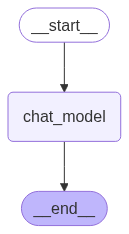

In [34]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about tracing and debugging!", name="Bin"))

In [36]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Bin

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching LangGraph?
================================ Human Message =================================
Name: Bin

Yes, I know about LangGraph and LangSmith. But what others should I learn about?
================================== Ai Message ==================================

In addition to LangGraph and LangSmith, there are several other tools and frameworks that you might find interesting in the field of natural language processing (NLP) and language modeling. Here are a few noteworthy ones:

1. **Hugging Face Transformers**: Hugging Face provides a wide range of pre-trained models and tools for NLP tasks such as text classification, translation, and more. Their Transformers library 

The message history tracks as the same before, but inside the `chat_model_node`, we can see how the `trim_messages` works:

In [37]:
# Example of trimming messages with `allow_partial=False`
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me more about tracing and debugging!', additional_kwargs={}, response_metadata={}, name='Bin', id='20d150b9-f391-44af-8dd0-eb7fab2f22d5')]

In [38]:
# Example of trimming messages with `allow_partial=True`
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True
        )

[AIMessage(content='\nLangSmith is ideal for developers who are looking to build robust and scalable applications using large language models, providing them with the necessary tools to enhance productivity and maintain high standards of application quality.\n\nIf you are working with language models or planning to do so, LangSmith can significantly streamline your development processes and improve the quality of your applications.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 393, 'prompt_tokens': 16, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C5Iv7vBcdKkeceRnou8MbEPJ3C6pu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--65adcd47-fe65-

# Chatbot with Message Summarization

In this section, we will use LLMs to produce a running summary of the conversation, rather than trimming or filtering messages.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

Then we will incorporate this summarization into a simple chatbot, and equipt that chatbot with memory, supporting long-running conversations without incurring high token cost or latency.

In [2]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')
os.environ['LANGSMITH_TRACING_V2'] = 'true'

In [3]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model='gpt-4o', temperature=0)

We will use `MessagesState`. In addition to the built-in `messages` key, we will also include a custom key `summary`.

In [4]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

We will define a node to call our LLM that incorporates a summary if it exists, into the prompt.

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage


# Define the logic to call the model
def call_model(state: State):
    # Get summary if it exists
    summary = state.get('summary', "")

    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        sys_msg = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=sys_msg)] + state['messages']

    else:
        messages = state['messages']

    response = model.invoke(messages)

    return {'messages': response}

We also need to define a node to produce a summary. NOTE: we will use `RemoveMessage` to filter our state after we have produced the summary.

In [6]:
def summarize_conversation(state: State):
    # 1. Get any existing summary
    summary = state.get('summary', '')

    # 2. Create our summarization prompt
    if summary:
        # 2.5. If a summary already exists
        summary_msg = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_msg = "Create a summary of the conversation above:"

    # 3. Add prompt to our history
    messages = state['messages'] + [HumanMessage(content=summary_msg)]

    # 4. Invoke for summary
    response = model.invoke(messages)

    # 5. Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]

    return {
        'messages': delete_messages,
        'summary': response.content
    }

We will then add a conditional edge to determine whether to produce a summary based on the conversation length.

In [7]:
from langgraph.graph import END
from typing_extensions import Literal

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal['summarize_conversation', END]:
    """Return the next node to execute."""
    messages = state['messages']

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    else:
        return END

## Adding memory

Recall that state is transient to a single graph execution, which limits our ability to have multi-turn conversations with interruptions.

LangGraph can use a checkpointer to automatically save the graph state after each step with *persistence*. This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest memory checkpointer is `MemorySaver`, which is an in-memory key-value store for Graph state.

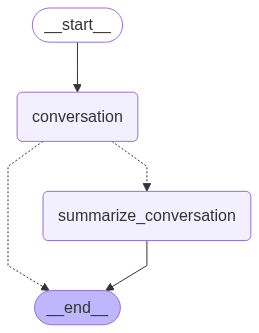

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Build
builder = StateGraph(State)
builder.add_node('conversation', call_model)
builder.add_node('summarize_conversation', summarize_conversation)

# Logic
builder.add_edge(START, 'conversation')
builder.add_conditional_edges('conversation', should_continue)
builder.add_edge('summarize_conversation', END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpint. These saved checkpoints can be grouped into a `thread` of conversation.

For example, threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

In [9]:
# Create a thread
config = {
    'configurable': {'thread_id': '1'}
}

# Start conversation
input_message = HumanMessage(content="Hello! I'm Bin.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I like the Golden State Warriors!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, Bin! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Bin. How can I help you today?
================================== Ai Message ==================================

That's great! The Golden State Warriors have a strong fan base and a rich history in the NBA. Do you have a favorite player or a memorable moment from the team that you'd like to share?


Now we can check if we have a summary of the state:

In [10]:
graph.get_state(config).values.get('summary', "")

''

In [13]:
print(f"Number of messages: {len(graph.get_state(config).values.get('messages'))}")

Number of messages: 6


We should not have any summary because we only have 6 messages so far. In the next round of conversation, we should have a non-empty summary.

The `config` with thread ID allows us to proceed from the previous logged state:

In [14]:
input_message = HumanMessage(content="I like Steph, What's his jersey number?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Stephen Curry's jersey number is 30. He's been a key player for the Golden State Warriors and is known for his incredible shooting skills. Do you have a favorite game or moment of his?


Now check the summary again:

In [15]:
graph.get_state(config).values.get('summary', "")

"In the conversation, Bin introduces themselves and expresses their interest in the Golden State Warriors, specifically mentioning their liking for Stephen Curry. The assistant responds by acknowledging Bin's interest and provides information about Stephen Curry's jersey number, which is 30. The assistant also invites Bin to share any favorite moments or games related to Curry or the Warriors."

# Chatbot with Message Summarization and External Database Memory

If we want our Chatbot to have memory that persists indefinitely. We need to introduce more advanced checkpointers that support external databases.

In this section, we will use Sqlite as a checkpointer for demo, but other checkpointers are also available.

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Sqlite

Sqlite is a small, fast, highly popular SQL database.

If we supply `":memory:"`, it creates an in-memory Sqlite database.

In [ ]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

If we supply a db path, then it will create a database for us.

In [ ]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [ ]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Now we re-define our chatbot.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Build
builder = StateGraph(State)
builder.add_node('conversation', call_model)
builder.add_node('summarize_conversation', summarize_conversation)

# Logic
builder.add_edge(START, 'conversation')
builder.add_conditional_edges('conversation', should_continue)
builder.add_edge('summarize_conversation', END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Create a thread
config = {
    'configurable': {'thread_id': '1'}
}

# Start conversation
input_message = HumanMessage(content="Hello! I'm Bin.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I like the Golden State Warriors!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Check if our state is saved locally:

In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

## Persisting state

Using database like Sqlite means state is persisted.

For example, we can re-start the notebook kernel and see that we can still load from Sqlite database on disk.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state